# ASSIGNMENT - 771767 - Feed Forward Neural Network with Hyperparameter Optimization
#### Student ID - 202102828

## Libraries

In [ ]:
!pip install keras-tuner

In [ ]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Inception-v3
from keras.applications.inception_v3 import preprocess_input

# DenseNet201
from keras.applications.densenet import preprocess_input

# kerastuner
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband, SklearnTuner

import timeit

## Load and prep the data

In [ ]:
data_dir = '/content/drive/MyDrive/Uni/Sem2/Applied AI/project/dataset/Garbage classification/Garbage classification'

batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

class_names = train_ds.class_names
class_names

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# cache the images
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
num_classes = len(class_names)

## Simple Feed-Forward Neural Network

In [ ]:
# function to plot the graphs between accuracy and loss

def plot_graph(history, n, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.savefig('waste_nn_' + str(n) + '.png')
    plt.show()

In [ ]:
# callbacks 
my_callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='auto'),
                #tf.keras.callbacks.ModelCheckpoint(filepath='model1.{epochs:02d}-{val_loss:.2f}.h5'),
                tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Uni/Sem2/Applied AI/project/dataset/Garbage classification/logs'),
]

In [ ]:
# train a basic feedforward neural net 
# model consists of 1 input layer, 1 hidden layer and 1 output layer
# hyperparameters => activation functions = ['relu', 'softmax'], optimizer='adam', loss=SparseCatgeoricalCrossentropy, metrics=['accuracy]
# epochs = 10
basic_model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
                    
])

# time to compile 
time_start = timeit.default_timer()
basic_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
time_stop = timeit.default_timer()
print('time taken : ', time_stop - time_start)

basic_model.summary()

time_start = timeit.default_timer()
history_basic_model = basic_model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=batch_size, callbacks=my_callbacks)
time_stop = timeit.default_timer()

print('Time taken for fitting model 1 :', (time_stop - time_start))

time taken :  0.006094162999943364
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 9,839,174
Trainable params: 9,839,174
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


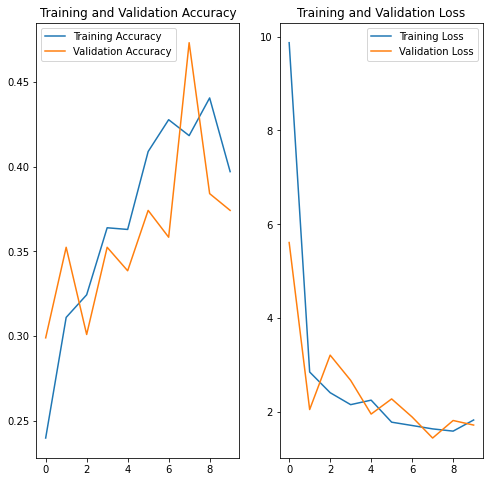

In [ ]:
# plot the graph showing the accuracy and loss
plot_graph(history_basic_model, 1, 10)

## Data Augmentation

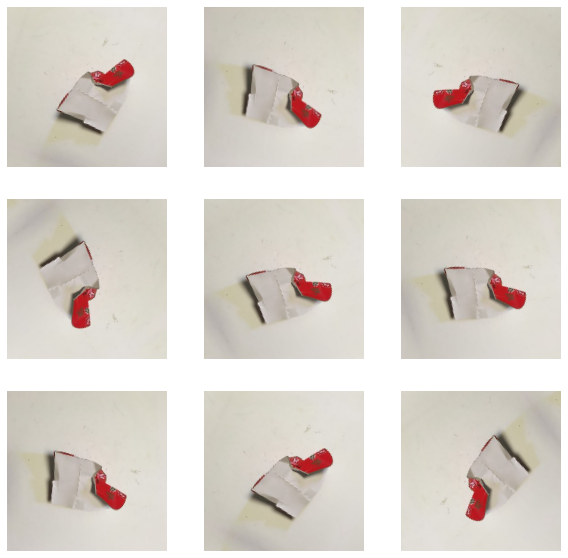

In [ ]:
data_augmentation = Sequential([
                                layers.experimental.preprocessing.RandomFlip('horizontal'),
                                layers.experimental.preprocessing.RandomRotation(0.2)
])

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_img = image[0]
  plt.title('Augmented Image')
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_img, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
  

(32, 160, 160, 3)
(32,)


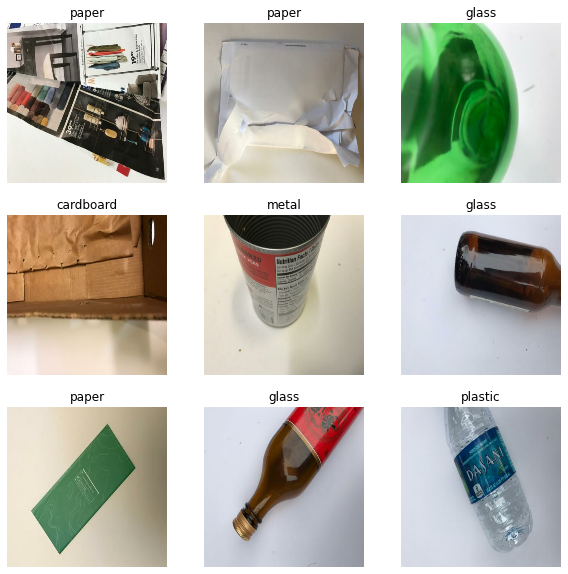

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels, in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
# train a basic feedforward neural net with augmented images
# model consists of 1 input layer, 1 hidden layer and 1 output layer
# hyperparameters => activation functions = ['relu', 'softmax'], optimizer='adam', loss=SparseCatgeoricalCrossentropy, metrics=['accuracy]
# epochs = 10
basic_model_augmented = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.experimental.preprocessing.RandomFlip('horizontal'),
                    layers.experimental.preprocessing.RandomRotation(0.2),
                    layers.Flatten(),
                    layers.Dense(512, activation='relu'),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])

# time to compile 
time_start = timeit.default_timer()
basic_model_augmented.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
time_stop = timeit.default_timer()
print('time taken : ', time_stop - time_start)

basic_model_augmented.summary()

time_start = timeit.default_timer()
history_basic_model_augmented = basic_model_augmented.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=batch_size)
time_stop = timeit.default_timer()

print('Time taken for fitting model 1 :', (time_stop - time_start))

time taken :  0.0034481059992685914
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 76800)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               39322112  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                  

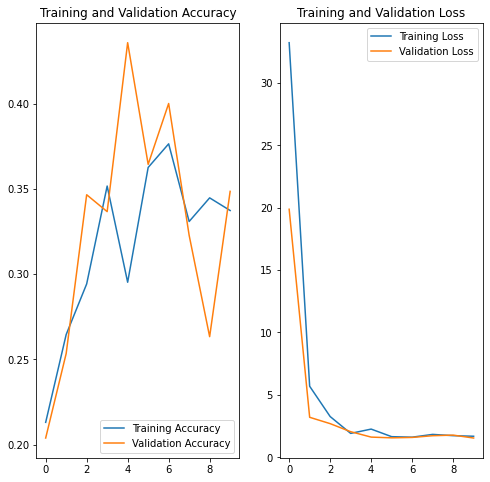

In [ ]:
plot_graph(history_basic_model_augmented, 2, 10)

## First CNN Model

In [ ]:
# cnn model

model_cnn = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])
# time to compile 
time_start = timeit.default_timer()
model_cnn.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
time_stop = timeit.default_timer()
print('time taken : ', time_stop - time_start)

model_cnn.summary()

epochs = 10
# time the process
time_start = timeit.default_timer()
history_model_cnn = model_cnn.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)
time_stop = timeit.default_timer()
print('Time taken for fitting model 1 :', (time_stop - time_start))

time taken :  0.003535928000928834
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 64)      18496     
                                                                 
 flatten_2 (Flatten)         (None, 1638400)           0         
                                                                 
 dense_6 (Dense)             (None, 128)               209715328 
                                                                 
 dense_7 (Dense)   

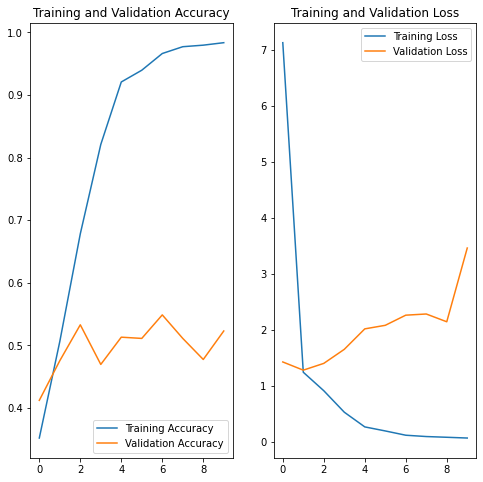

In [ ]:
plot_graph(history_model_cnn, 3, 10)

In [ ]:
model_cnn.evaluate(val_ds)

16/16 [==============================] - 0s 26ms/step - loss: 3.4597 - accuracy: 0.5228


[3.4596917629241943, 0.5227722525596619]

## Second CNN Model

In [ ]:
# cnn model with AveragePooling, MaxPooling and Dropout layer

model_cnn2 = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.AveragePooling2D(),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.5),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(8, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')
])
# time to compile 
time_start = timeit.default_timer()
model_cnn2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
time_stop = timeit.default_timer()
print('time taken : ', time_stop - time_start)

model_cnn2.summary()

epochs = 20
# time the process
time_start = timeit.default_timer()
history_model_cnn2 = model_cnn2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)
time_stop = timeit.default_timer()
print('Time taken for fitting model 1 :', (time_stop - time_start))

time taken :  0.0034083299979101866
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 80, 80, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 max_pooling2d_1 (

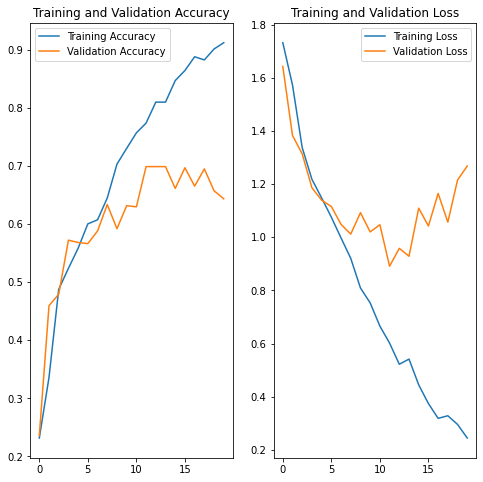

In [ ]:
plot_graph(history_model_cnn2, 4, 20)

## Hyperparameter tuning

In [ ]:
# define the kerastuner model

def build_model(hp):
  # define the model
  model = tf.keras.Sequential()
  
  # add the layers
  model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
  model.add(layers.AveragePooling2D())
  
  for i in range(hp.Int('Conv layer', min_value=1, max_value=5)):
    model.add(layers.Conv2D(
        hp.Choice(f'layer_{i}_filters', [16, 32, 64, 128, 256, 512]),
        3,
        padding='same', 
        activation='relu'))
    model.add(layers.MaxPooling2D(hp.Choice(f'maxpool_{i}_layer', [1, 2])))
    #model.add(layers.MaxPooling2D())

  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu')),
  model.add(layers.Dense(64, activation='relu')),
  model.add(layers.Dense(8, activation='relu')),
  model.add(layers.Dense(num_classes, activation='softmax'))

  # compile the model
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

**Keras Tuner - RandomSearch**

In [ ]:
# define the tuner variable

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    overwrite=True
)

In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=20, batch_size=batch_size)

Trial 5 Complete [00h 00m 12s]
val_accuracy: 0.6693069338798523

Best val_accuracy So Far: 0.6693069338798523
Total elapsed time: 00h 10m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 80, 80, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0

In [ ]:
history_random = best_model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
64/64 [==============================] - 1s 10ms/step - loss: 0.1687 - accuracy: 0.9466 - val_loss: 1.4432 - val_accuracy: 0.6535
Epoch 2/20
64/64 [==============================] - 1s 8ms/step - loss: 0.1506 - accuracy: 0.9496 - val_loss: 1.4597 - val_accuracy: 0.6693
Epoch 3/20
64/64 [==============================] - 1s 8ms/step - loss: 0.1699 - accuracy: 0.9456 - val_loss: 1.3225 - val_accuracy: 0.6495
Epoch 4/20
64/64 [==============================] - 1s 8ms/step - loss: 0.1050 - accuracy: 0.9639 - val_loss: 1.4184 - val_accuracy: 0.6396
Epoch 5/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0973 - accuracy: 0.9679 - val_loss: 1.5590 - val_accuracy: 0.6634
Epoch 6/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0971 - accuracy: 0.9718 - val_loss: 1.5489 - val_accuracy: 0.6198
Epoch 7/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0805 - accuracy: 0.9718 - val_loss: 1.7830 - val_accuracy: 0.6297
Epoch 8/20
64/64 [=

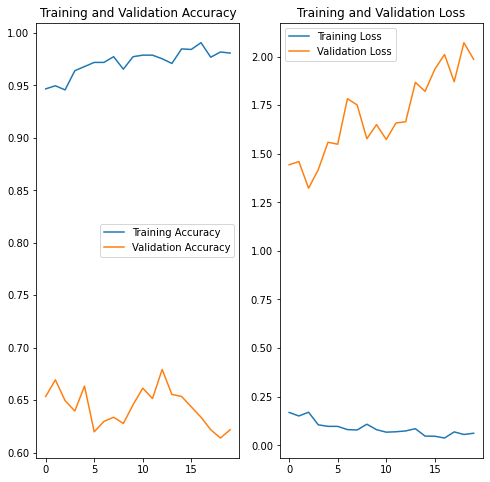

In [ ]:
plot_graph(history_random, 5, 20)

**Kerastuner - bayesian**

In [ ]:
# define kerastuner function for bayesian model
tuner_bayesian = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='BayesianOptimization',
    overwrite=True
)

In [ ]:
tuner_bayesian.search(train_ds, validation_data=val_ds, epochs=20, batch_size=batch_size)

Trial 5 Complete [00h 00m 44s]
val_accuracy: 0.6376237869262695

Best val_accuracy So Far: 0.6435643434524536
Total elapsed time: 00h 11m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model_bayesian = tuner_bayesian.get_best_models()[0]

In [ ]:
best_model_bayesian.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 80, 80, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 512)       74240     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 512)      0

In [ ]:
history_bayesian = best_model_bayesian.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
64/64 [==============================] - 5s 76ms/step - loss: 0.5486 - accuracy: 0.8136 - val_loss: 1.0702 - val_accuracy: 0.6455
Epoch 2/20
64/64 [==============================] - 5s 73ms/step - loss: 0.5526 - accuracy: 0.7987 - val_loss: 1.0962 - val_accuracy: 0.6495
Epoch 3/20
64/64 [==============================] - 5s 73ms/step - loss: 0.5416 - accuracy: 0.8076 - val_loss: 1.1973 - val_accuracy: 0.6337
Epoch 4/20
64/64 [==============================] - 5s 73ms/step - loss: 0.5094 - accuracy: 0.8343 - val_loss: 1.2679 - val_accuracy: 0.6238
Epoch 5/20
64/64 [==============================] - 5s 73ms/step - loss: 0.4504 - accuracy: 0.8373 - val_loss: 1.2306 - val_accuracy: 0.6436
Epoch 6/20
64/64 [==============================] - 5s 73ms/step - loss: 0.4517 - accuracy: 0.8482 - val_loss: 1.1721 - val_accuracy: 0.6653
Epoch 7/20
64/64 [==============================] - 5s 73ms/step - loss: 0.3911 - accuracy: 0.8650 - val_loss: 1.2465 - val_accuracy: 0.6614
Epoch 8/20
64

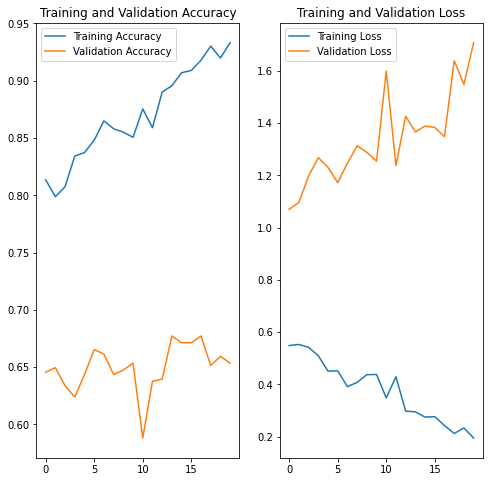

In [ ]:
plot_graph(history_bayesian, 5, 20)

Kerastuner - hyperband

In [ ]:
# define kerastuner function for hyperband model
tuner_hyperband = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='Hyperband',
    overwrite=True
)

In [ ]:
tuner_hyperband.search(train_ds, validation_data=val_ds, epochs=20, batch_size=batch_size)

Trial 5 Complete [00h 02m 11s]
val_accuracy: 0.4455445408821106

Best val_accuracy So Far: 0.6237623691558838
Total elapsed time: 00h 09m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model_hyperband = tuner_hyperband.get_best_models()[0]

In [ ]:
best_model_hyperband.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 80, 80, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 16)        73744     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 16)       0

In [ ]:
history_hyperband = best_model_hyperband.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
64/64 [==============================] - 4s 50ms/step - loss: 0.8297 - accuracy: 0.6790 - val_loss: 1.1440 - val_accuracy: 0.5960
Epoch 2/20
64/64 [==============================] - 3s 48ms/step - loss: 0.7680 - accuracy: 0.7136 - val_loss: 1.1342 - val_accuracy: 0.6178
Epoch 3/20
64/64 [==============================] - 3s 47ms/step - loss: 0.7417 - accuracy: 0.7166 - val_loss: 1.0997 - val_accuracy: 0.6277
Epoch 4/20
64/64 [==============================] - 3s 47ms/step - loss: 0.6716 - accuracy: 0.7517 - val_loss: 1.1617 - val_accuracy: 0.6475
Epoch 5/20
64/64 [==============================] - 3s 47ms/step - loss: 0.6185 - accuracy: 0.7646 - val_loss: 1.1506 - val_accuracy: 0.6297
Epoch 6/20
64/64 [==============================] - 3s 47ms/step - loss: 0.7082 - accuracy: 0.7428 - val_loss: 1.0977 - val_accuracy: 0.6416
Epoch 7/20
64/64 [==============================] - 3s 47ms/step - loss: 0.6044 - accuracy: 0.7844 - val_loss: 1.1448 - val_accuracy: 0.6376
Epoch 8/20
64

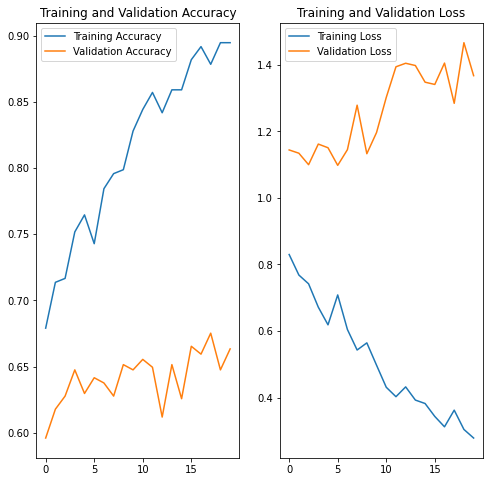

In [ ]:
plot_graph(history_hyperband, 6, 20)

## Inception-v3 (pre-trained model)

In [ ]:
# creating the inception model
model_inception = tf.keras.applications.InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
feature_batch = model_inception(image_batch)

In [ ]:
feature_batch.shape

TensorShape([32, 3, 3, 2048])

In [ ]:
model_inception.trainable = False
model_inception.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 79, 32)  96          ['conv2d_5[0][0]']               
 alization)                                                                                       
                                                                                       

In [ ]:
# preprocess the input to rescale the shape to (-1, 1)

preprocess_input_ = preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input_(x)
x = model_inception(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()
len(model.trainable_variables)

initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

history_inception = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        218027

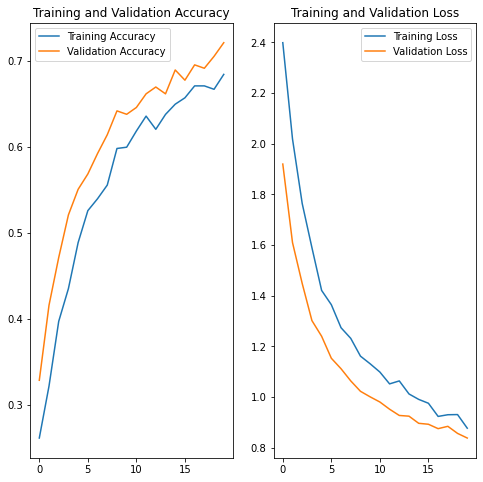

In [ ]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']

loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs_range = range(epochs)
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# total number of layers in model
print('Number of layers in model :', len(model_inception.layers))

Number of layers in model : 311


In [ ]:
# fine tuning the inception model

model_inception.trainable = True
model_inception.summary()

# fine tune from this layer 
fine_tune_at = 100

# freeze the layers before fine_tune_at layer
for layer in model_inception.layers[:fine_tune_at]:
  layer.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 79, 32)  96          ['conv2d_5[0][0]']               
 alization)                                                                                       
                                                                                       

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_inception.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
64/64 [==============================] - 19s 135ms/step - loss: 0.8226 - accuracy: 0.7043 - val_loss: 0.7262 - val_accuracy: 0.7366
Epoch 21/30
64/64 [==============================] - 7s 106ms/step - loss: 0.6610 - accuracy: 0.7606 - val_loss: 0.6728 - val_accuracy: 0.7683
Epoch 22/30
64/64 [==============================] - 7s 107ms/step - loss: 0.5436 - accuracy: 0.8145 - val_loss: 0.6030 - val_accuracy: 0.7723
Epoch 23/30
64/64 [==============================] - 7s 109ms/step - loss: 0.4593 - accuracy: 0.8358 - val_loss: 0.5708 - val_accuracy: 0.7980
Epoch 24/30
64/64 [==============================] - 7s 108ms/step - loss: 0.4085 - accuracy: 0.8600 - val_loss: 0.5412 - val_accuracy: 0.8139
Epoch 25/30
64/64 [==============================] - 7s 108ms/step - loss: 0.3577 - accuracy: 0.8694 - val_loss: 0.5384 - val_accuracy: 0.8356
Epoch 26/30
64/64 [==============================] - 7s 107ms/step - loss: 0.3033 - accuracy: 0.8942 - val_loss: 0.5052 - val_accuracy: 0.833

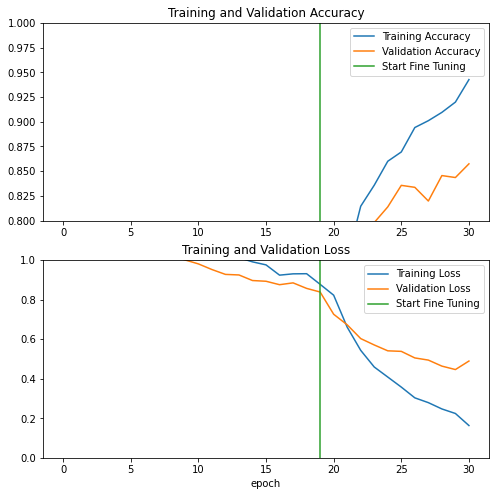

16/16 [==============================] - 1s 40ms/step - loss: 0.4895 - accuracy: 0.8574
Test accuracy : 0.8574257493019104


In [ ]:
# plot the graph showing fine tuning

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

## DenseNet201 (pre-trained model)

In [ ]:
# creating the DenseNet201 model
model_densenet201 = tf.keras.applications.DenseNet201(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
feature_batch = model_densenet201(image_batch)

In [ ]:
model_densenet201.trainable = False
model_densenet201.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
preprocess_input_ = tf.keras.applications.densenet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input_(x)
x = model_densenet201(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()
len(model.trainable_variables)

initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

history_densenet201 = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                           

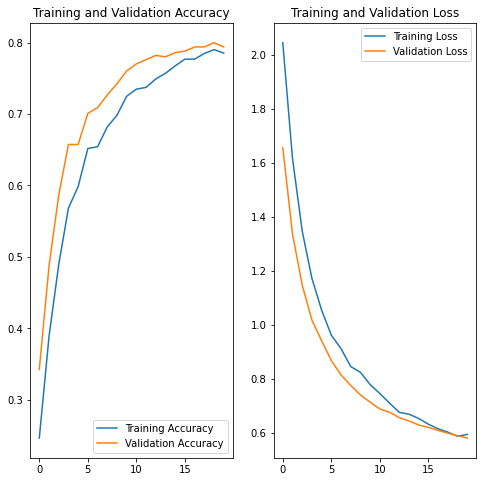

In [ ]:
acc = history_densenet201.history['accuracy']
val_acc = history_densenet201.history['val_accuracy']

loss = history_densenet201.history['loss']
val_loss = history_densenet201.history['val_loss']

epochs_range = range(epochs)
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# total number of layers in model
print('Number of layers in model :', len(model_densenet201.layers))

Number of layers in model : 707


In [ ]:
# fine tuning the DenseNet201 model

model_densenet201.trainable = True
model_densenet201.summary()

# fine tune from this layer 
fine_tune_at = 300

# freeze the layers before fine_tune_at layer
for layer in model_densenet201.layers[:fine_tune_at]:
  layer.trainable = False

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_densenet = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_inception.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
64/64 [==============================] - 44s 287ms/step - loss: 0.5251 - accuracy: 0.8091 - val_loss: 0.4838 - val_accuracy: 0.8198
Epoch 21/30
64/64 [==============================] - 14s 222ms/step - loss: 0.4071 - accuracy: 0.8591 - val_loss: 0.4373 - val_accuracy: 0.8436
Epoch 22/30
64/64 [==============================] - 14s 223ms/step - loss: 0.3196 - accuracy: 0.8917 - val_loss: 0.3844 - val_accuracy: 0.8653
Epoch 23/30
64/64 [==============================] - 14s 220ms/step - loss: 0.2832 - accuracy: 0.8961 - val_loss: 0.3695 - val_accuracy: 0.8634
Epoch 24/30
64/64 [==============================] - 14s 219ms/step - loss: 0.2266 - accuracy: 0.9115 - val_loss: 0.3839 - val_accuracy: 0.8495
Epoch 25/30
64/64 [==============================] - 14s 219ms/step - loss: 0.2002 - accuracy: 0.9278 - val_loss: 0.3449 - val_accuracy: 0.8832
Epoch 26/30
64/64 [==============================] - 14s 220ms/step - loss: 0.1662 - accuracy: 0.9421 - val_loss: 0.3207 - val_accuracy:

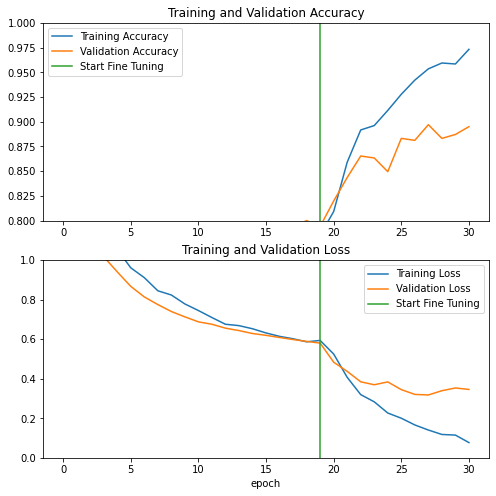

16/16 [==============================] - 1s 87ms/step - loss: 0.3459 - accuracy: 0.8950
Test accuracy : 0.895049512386322


In [ ]:
# plot the graph showing fine tuning

acc += history_fine_densenet.history['accuracy']
val_acc += history_fine_densenet.history['val_accuracy']

loss += history_fine_densenet.history['loss']
val_loss += history_fine_densenet.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)